In [15]:
import mdtraj as md
import pyemma as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional, Union, Tuple
from pathlib import Path
import pickle
import seaborn as sns
import os

import matplotlib as mpl
from matplotlib import colors

from msmtools.estimation import transition_matrix as _transition_matrix
from msmtools.analysis import timescales as _timescales

import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral, Ramachandran

In [17]:
mpl.rcParams['savefig.bbox'] = 'tight'
sns.set_style("white")
sns.set_style({'font.family':'sans-serif', 'font.serif':'Arial'})

In [3]:
def featurizer(hp_dict: Dict, traj_paths: List[str], top_path: str) -> List[np.ndarray]:
    if hp_dict['feature__value'] == 'dihedrals':
        assert hp_dict['dihedrals__which'] == 'all'
        def f(traj: md.Trajectory, **kwargs) -> np.ndarray:
            _, phi = md.compute_phi(traj)
            _, psi = md.compute_psi(traj)
            _, chi1 = md.compute_chi1(traj)
            _, chi2 = md.compute_chi2(traj)
            _, chi3 = md.compute_chi3(traj)
            _, chi4 = md.compute_chi4(traj)
            _, chi5 = md.compute_chi5(traj)
            ftraj = np.concatenate([phi, psi, chi1, chi2, chi3, chi4, chi5], axis=1)
            ftraj = np.concatenate([np.cos(ftraj), np.sin(ftraj)], axis=1)
            return ftraj

    elif hp_dict['feature__value'] == 'distances':
        def f(traj: md.Trajectory, **kwargs):
            scheme = kwargs['distances__scheme']
            transform = kwargs['distances__transform']
            centre = kwargs['distances__centre']
            steepness = kwargs['distances__steepness']
            ftraj, _ = md.compute_contacts(traj, scheme=scheme)
            if transform=='logistic':
                ftraj = 1.0/(1+np.exp(-steepness*(ftraj - centre)))
            return ftraj
    else:
        raise ValueError
    ftrajs = []
    for traj_path in traj_paths:
        traj = md.load(traj_path, top=top_path)
        ftrajs.append(f(traj, **hp_dict))
    return ftrajs


def tica(hp_dict: Dict[str, Union[float, int, str]], ftrajs: List[np.ndarray]) -> List[np.ndarray]:
    lag = hp_dict['tica__lag']
    stride = hp_dict['tica__stride']
    dim = hp_dict['tica__dim']
    tica = pm.coordinates.tica(ftrajs, lag=lag, dim=dim, kinetic_map=True)
    ttrajs = tica.get_output()
    return ttrajs, tica

def kmeans(hp_dict: Dict, ttrajs: List[np.ndarray], seed: int) -> List[np.ndarray]:
    k = hp_dict['cluster__k']
    max_iter = hp_dict['cluster__max_iter']
    stride = hp_dict['cluster__stride']
    kmeans = pm.coordinates.cluster_kmeans(ttrajs, k=k, max_iter=max_iter, stride=stride, fixed_seed=seed, n_jobs=1)
    dtrajs = kmeans.dtrajs
    return dtrajs, kmeans


def its(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    its_obj = pm.msm.timescales_msm(dtrajs=dtrajs, lags=lags, nits=nits)
    return its_obj.timescales


def score(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    all_vs = []
    for lag in lags: 
        m = pm.msm.estimate_markov_model(dtrajs, lag=lag)
        vs = np.array([m.score(dtrajs, score_k=k) for k in range(2, nits+2)])
        vs = vs.reshape(1, -1)
        all_vs.append(vs)
    all_vs = np.concatenate(all_vs, axis=0)
    return all_vs
        


def bootstrap(ftrajs: List[np.ndarray], rng: np.random.Generator) -> List[np.ndarray]:
    probs = np.array([x.shape[0] for x in ftrajs])
    probs = probs/np.sum(probs)
    ix = np.arange(len(ftrajs))
    new_ix = rng.choice(ix,size=len(ftrajs), p=probs, replace=True)
    return [ftrajs[i] for i in new_ix], new_ix



def summarise(df):
    df_summary = df.groupby(['hp_ix', 'lag', 'process']).agg(median=(0, lambda x: np.quantile(x, 0.5)),
                                                                   lb=(0, lambda x: np.quantile(x, 0.025)),
                                                                   ub=(0, lambda x: np.quantile(x, 0.975)), 
                                                                   count =(0, lambda x: x.shape[0]-x.isna().sum()))
    return df_summary


def samples_to_summary(samples: np.ndarray, lags: List[int],  hp_ix: int)-> pd.DataFrame: 
    """
    samples=np.ndarray[lagtime, process, bs_sample]
    """
    df = pd.concat({(hp_ix, lags[i], j+2): pd.DataFrame(samples[i, j, :]) for i in range(samples.shape[0]) for j in range(samples.shape[1])})
    df.index.rename(('hp_ix', 'lag', 'process', 'bs_ix'), inplace=True)
    df_summary = summarise(df)
    return df_summary

In [49]:
# MSM parameters
protein = 'CLN'
seed = 49587
rng = np.random.default_rng(seed)
lags = list(range(1, 102, 10))
n_bootstraps = 1
nits= 25
lag = 31
hp_ixs = [52, 218]
hp_ix = 218
n_ts = 10

# PCCA+ parameters
n_sets = 2
core_membership_cutoff = 0.9

# Input path 
summary_path = r'../CLN/maximize_t2.h5'

top_path = '../../../chignolin/protein.pdb'
traj_paths = list(Path(r'../../../chignolin').rglob(f'CLN025-0-protein-*.xtc'))
traj_paths = [str(x) for x in traj_paths]
traj_paths.sort()
ref_path = r'../../../chignolin/5AWL_H.pdb'

In [50]:
hps = pd.read_hdf(summary_path)

hps.rename(columns=dict(number='hp_ix', 
                        params_centre='distances__centre', 
                        params_feature='feature__value', 
                        params_n_clusters='cluster__k', 
                        params_scheme='distances__scheme', 
                        params_steepness='distances__steepness', 
                        params_tica_dim='tica__dim', 
                        params_tica_lag='tica__lag', 
                        params_transform='distances__transform'), inplace=True)
hps['tica__stride'] = 1
hps['cluster__stride'] = 1
hps['dihedrals__which'] = 'all'
hps['cluster__max_iter'] = 1000
hps['feature'] = hps.apply(lambda x: f"{x['feature__value']}" if x['feature__value'] =='dihedrals' else f"{x['distances__transform']}-{x['feature__value']}", axis=1)

def f(x):
    for short, long in short_names.items(): 
        x = x.replace(short, long)
    return x

short_names = {'dihedrals': 'dihed.','logistic-distances': 'logit(dist.)', 'linear-distances': 
              'dist.'}

hps['feature'] = hps['feature'].apply(f)

hps.sort_values(by='value', inplace=True, axis=0, ascending=False)
hps['rank'] = (np.arange(hps.shape[0])+1).astype(int)

In [43]:
for ix in hp_ixs: print(hps.loc[ix, :].to_dict())

{'hp_ix': 52, 'value': 379.42782419807565, 'datetime_start': Timestamp('2022-12-14 16:14:41.274420'), 'datetime_complete': Timestamp('2022-12-14 16:14:41.274420'), 'duration': Timedelta('0 days 00:00:00'), 'distances__centre': nan, 'feature__value': 'distances', 'cluster__k': 488, 'distances__scheme': 'ca', 'distances__steepness': nan, 'tica__dim': 15, 'tica__lag': 71, 'distances__transform': 'linear', 'state': 'COMPLETE', 'tica__stride': 1, 'cluster__stride': 1, 'dihedrals__which': 'all', 'cluster__max_iter': 1000, 'feature': 'dist.', 'rank': 57}
{'hp_ix': 218, 'value': 388.1926536231141, 'datetime_start': Timestamp('2022-12-14 18:53:54.379169'), 'datetime_complete': Timestamp('2022-12-14 18:55:59.432164'), 'duration': Timedelta('0 days 00:02:05.052995'), 'distances__centre': nan, 'feature__value': 'distances', 'cluster__k': 469, 'distances__scheme': 'ca', 'distances__steepness': nan, 'tica__dim': 15, 'tica__lag': 3, 'distances__transform': 'linear', 'state': 'COMPLETE', 'tica__stride

***
### Compute and check MSM

In [51]:
# Output path 
hps.set_index(['hp_ix'], inplace=True)
base_dir = Path(f"{protein}/hp{hp_ix}_{hps.loc[hp_ix,:]['feature']}")
fig_dir = Path.joinpath(base_dir, Path(f"figures"))
fig_dir.mkdir(parents=True, exist_ok=True)

In [52]:
ftrajs_all = featurizer(hps.loc[hp_ix,:].to_dict(), traj_paths, top_path)

# Bootstrap results
ts_samples = []
vs_samples = []

for i in range(n_bootstraps):
    ftrajs = ftrajs_all
    assert len(ftrajs) == len(ftrajs_all)
    
    ttrajs, tica_mod = tica(hps.loc[hp_ix, :].to_dict(), ftrajs)
    dtrajs, kmeans_mod = kmeans(hps.loc[hp_ix, :].to_dict(), ttrajs, seed)
    
    if n_bootstraps>1:
        out_dir = Path.joinpath(base_dir, Path(f'bs_{i}'))
    else:
        out_dir = Path.joinpath(base_dir, Path(f'dtrajs'))
        
    out_dir.mkdir(parents=True, exist_ok=True)
    
    for j in range(len(traj_paths)): 
        traj_path = Path(traj_paths[j]).resolve()
        np.save(file=out_dir.joinpath(traj_path.with_suffix('.npy').name), arr=dtrajs[j])
        
msm = pm.msm.estimate_markov_model(dtrajs, lag=lag)
_ = msm.pcca(n_sets)
ts = msm.timescales(n_ts)

/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████████████████| 54/54 [00:00<00:00, 995.50it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%|  | 0/469 [00:00<?, ?it/s]
initialize kmeans++ centers:  99%|▉| 464/469 [00:06<00:00, 7
kmeans iterations:   2%|  | 25/1000 [00:22<09:58,  1.63it/s]
initialize kmeans++ centers: 100%|█| 469/469 [00:23<00:00, 7
100%|███████████████████

[381.46040906  17.95738455  17.74533557  17.57672958  17.54173317
  17.45330646  17.38801858  17.37976465  17.2537857   17.20382007]


/tmp/ipykernel_2405693/111038820.py:18: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[1].set_ylim([0,5])


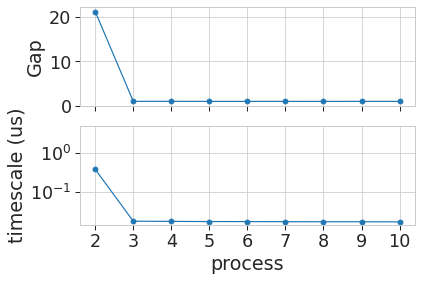

In [34]:
'''
top panel --> plot ratios of ts_n / ts_(n+1)
bottom panel --> values of timescales
'''

print(ts)
with sns.plotting_context('paper', font_scale=2):
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(2, sharex=True)

    axes[0].plot(np.arange(n_ts-1)+2, ts[:-1]/ts[1:], marker='o')
    axes[0].set_ylabel('Gap')
    
    axes[1].plot(np.arange(n_ts-1)+2, ts[:-1]/1000, marker='o')
    axes[1].set_yscale('log')
    axes[1].set_ylabel('timescale (us)')
    axes[1].set_xlabel('process')
    axes[1].set_ylim([0,5])
    
    axes[0].tick_params(bottom=True, top=False, left=True, right=False)
    axes[1].tick_params(bottom=True, top=False, left=True, right=False)

    plt.savefig(fig_dir.joinpath(f'Timescales.png'), bbox_inches='tight')

In [53]:
# Check state disconnectivity --- only the largest set of reversibly connected states were used in MSM estimation

print('Fraction of states used = {:f}'.format(msm.active_state_fraction))
print('Fraction of counts used = {:f}'.format(msm.active_count_fraction))

print(f'Microstate assignment: {np.concatenate(ttrajs).shape}')
print(f'Right eigenvectors dimension: {msm.eigenvectors_right().shape}')

# Check population
print('\nstate\tπ\t\tG/kT\t\tNo.')
population = []
number = []
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    population.append(p)
    number.append(s.shape[0])
    print('{}\t{:f}\t{:f}\t{}'.format(i, p, -np.log(p), s.shape[0]))

Fraction of states used = 1.000000
Fraction of counts used = 1.000000
Microstate assignment: (106949, 15)
Right eigenvectors dimension: (469, 469)

state	π		G/kT		No.
0	0.219532	1.516256	381
1	0.780468	0.247862	88


In [54]:
Y = np.concatenate(ttrajs)

dists = msm.metastable_distributions.copy()
dists[msm.metastable_memberships.T<core_membership_cutoff] = 0
dists = dists/np.sum(dists, axis=1)[:, np.newaxis]

max_dists = dists.copy()
mask = max_dists==np.tile(np.max(max_dists, axis=1)[:, np.newaxis], (max_dists.shape[1]))
max_ix = np.where(mask)[1]
max_dists[mask] = 1
max_dists[~mask] = 0

In [37]:
# Mapping test conformations using maximum likelihood MSM 

test_traj_path = [r'../../../chignolin/5AWL_H.pdb']
test_labels = ['5AWL']
ftraj_test = featurizer(hps.loc[hp_ix, :].to_dict(), test_traj_path, top_path)
ftraj_test_tica = tica_mod.transform(ftraj_test)
microstate = kmeans_mod.assign(ftraj_test_tica)
metastate = msm.metastable_assignments[microstate]
test_dict = {label:[test_traj_path[i], microstate[i][0], metastate[i][0]] for i, label in enumerate(test_labels)}

***
### Check eigenvector

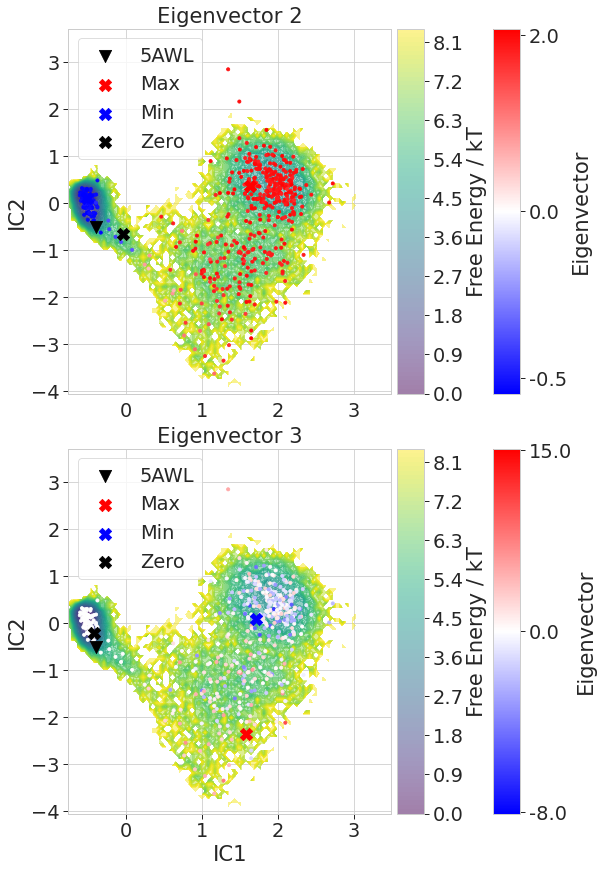

In [38]:
n_egv = 2
axes = []

with sns.plotting_context('paper', font_scale=2.2):
    fig = plt.figure(figsize=(n_egv*6, n_egv*6), constrained_layout=True)
    gs = fig.add_gridspec(nrows=n_egv*12, ncols=n_egv*12)
    
    for i in range(n_egv):
        axes.append([fig.add_subplot(gs[i*12:(i+1)*12, 0:12]), fig.add_subplot(gs[i*12:(i+1)*12,12]), fig.add_subplot(gs[i*12:(i+1)*12,13])])
    
    for i_ev, ax in enumerate(axes): 
        #vmin = np.min(msm.eigenvectors_right()[:, 1:3])
        #vmax = np.max(msm.eigenvectors_right()[:, 1:3])
        #lnorm = colors.Normalize(vmin=vmin, vmax=vmax)
        vmin = np.min(msm.eigenvectors_right()[:, i_ev+1]) 
        vmax = np.max(msm.eigenvectors_right()[:, i_ev+1]) 
        divnorm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

        if Y.shape[1]==1:
            pm.plots.plot_feature_histograms(Y, ax=ax)
            x = kmeans_mod.clustercenters[:, 0]
            y = np.repeat(0,kmeans_mod.clustercenters.shape[0])
        else:
            _, _ = pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], cmap='viridis', 
                                                alpha=0.5, weights=np.concatenate(msm.trajectory_weights()),
                                                cbar_label='Free Energy / kT', 
                                                ax=ax[0], cax=ax[1])
            x = kmeans_mod.clustercenters[:, 0]
            y = kmeans_mod.clustercenters[:, 1]    
        
        # Cluster centers and colorbar
        ms = ax[0].scatter(x=x, y=y, c=msm.eigenvectors_right()[:, i_ev+1], cmap='bwr', norm=divnorm, s=10)
        cbar = plt.colorbar(ms, cax=ax[2], ticks=[np.ceil(vmin*10)/10, 0, np.floor(vmax*10)/10])
        cbar.ax.set_yticklabels([np.ceil(vmin*10)/10, 0.0, np.floor(vmax*10)/10])
        cbar.ax.set_ylabel('Eigenvector')
        
        for k,v in test_dict.items():
            ax[0].scatter(x=x[v[1]], y=y[v[1]], c='black', marker='v', s=150, label=k, alpha=1)
        
        # Label extreme eigenvalues
        egv_max = msm.eigenvectors_right()[:, i_ev+1].argmax()
        egv_min = msm.eigenvectors_right()[:, i_ev+1].argmin()
        egv_zero = abs(msm.eigenvectors_right()[:, i_ev+1]).argmin()
        ax[0].scatter(x=x[egv_max], y=y[egv_max], c=msm.eigenvectors_right()[egv_max, i_ev+1], 
                      cmap='bwr', norm=divnorm, marker='X', s=150, alpha=1, label='Max')
        ax[0].scatter(x=x[egv_min], y=y[egv_min], c=msm.eigenvectors_right()[egv_min, i_ev+1], 
                      cmap='bwr', norm=divnorm, marker='X', s=150, alpha=1, label='Min')
        ax[0].scatter(x=x[egv_zero], y=y[egv_zero], c='k', marker='X', s=150, alpha=1, label='Zero')
    
        plt.locator_params(nbins=5, axis='both')
        ax[0].set_title(f'Eigenvector {i_ev+2}')
        ax[0].grid(visible=True, axis='both')
        ax[0].set_ylabel('IC2')
        ax[0].tick_params(bottom=True, top=False, left=True, right=False)
        ax[0].legend(loc='upper left')
        
    axes[0][0].tick_params(bottom=False, top=False, left=True, right=False)
    axes[1][0].tick_params(bottom=True, top=False, left=True, right=False)
    axes[1][0].set_xlabel('IC1')
    
    plt.savefig(fig_dir.joinpath(f'egvs.png'), bbox_inches='tight')    
    plt.show()

***
### Check state centers

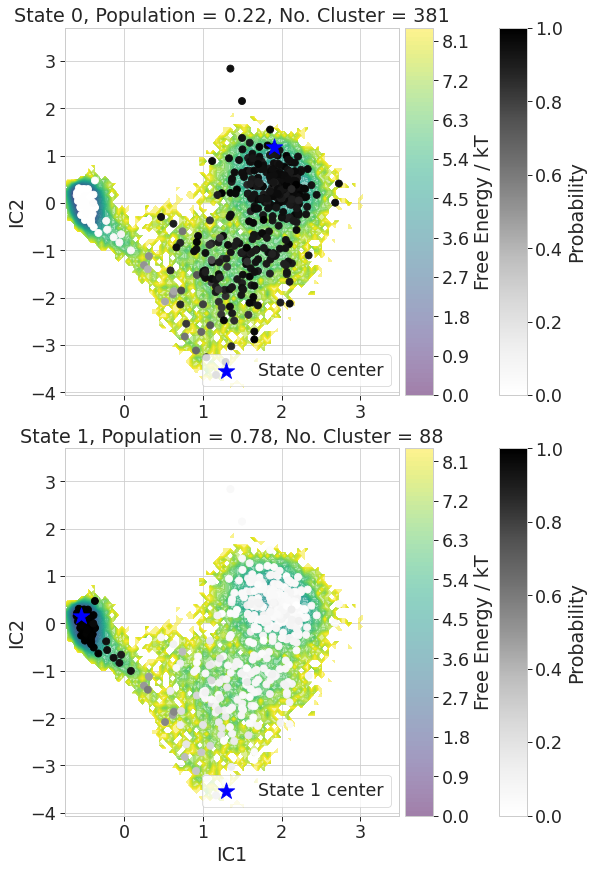

In [39]:
mem = msm.metastable_memberships.transpose()
axes = []

with sns.plotting_context('paper', font_scale=2):
    fig = plt.figure(figsize=(n_sets*6, n_sets*6), constrained_layout=True)
    gs = fig.add_gridspec(nrows=n_sets*12, ncols=n_sets*12)
    
    for i in range(n_sets):
        axes.append([fig.add_subplot(gs[i*12:(i+1)*12, 0:12]), fig.add_subplot(gs[i*12:(i+1)*12,12]), fig.add_subplot(gs[i*12:(i+1)*12,13])])
    
    for i_set, ax in enumerate(axes):
        if Y.shape[1]==1:
            pm.plots.plot_feature_histograms(Y, ax=ax[0])
            x = kmeans_mod.clustercenters[:, 0]
            y = np.repeat(0,kmeans_mod.clustercenters.shape[0])
        else:
            _, _ = pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], cmap='viridis', 
                                                alpha=0.5, weights=np.concatenate(msm.trajectory_weights()),
                                                cbar_label='Free Energy / kT', 
                                                ax=ax[0], cax=ax[1])
            x = kmeans_mod.clustercenters[:, 0]
            y = kmeans_mod.clustercenters[:, 1]    
        
        # Cluster centers
        ms = ax[0].scatter(x=x, y=y, c=mem[i_set], cmap='Greys', s=50, 
                           vmin=mem[i_set].min(), vmax=mem[i_set].max())
        cbar = plt.colorbar(ms, cax=ax[2])
        cbar.ax.set_ylabel('Probability')
        
        # State centers
        ax[0].scatter(x=x[max_ix[i_set]],y=y[max_ix[i_set]], color='b', marker='*', s=300, label=f'State {i_set} center')
        
        ax[0].grid(visible=True,axis='both')
        ax[0].set_title(f'State {i_set}, Population = {population[i_set]:.2f}, No. Cluster = {number[i_set]}')
        ax[0].tick_params(bottom=True, top=False, left=True, right=False)
        ax[0].legend(loc='lower right')
        ax[0].set_ylabel('IC2')
    '''
    for i, m in enumerate(microstate):
        axes[metastate[i][0]].scatter(x=x[m],y=y[m], color='r', marker='v', s=120, label= test_labels[i])
    '''    
    axes[i_set][0].set_xlabel('IC1')
    plt.locator_params(nbins=5, axis='both')
    
    plt.savefig(fig_dir.joinpath(f'{n_sets}_sc.png'), bbox_inches='tight')    
    plt.show()

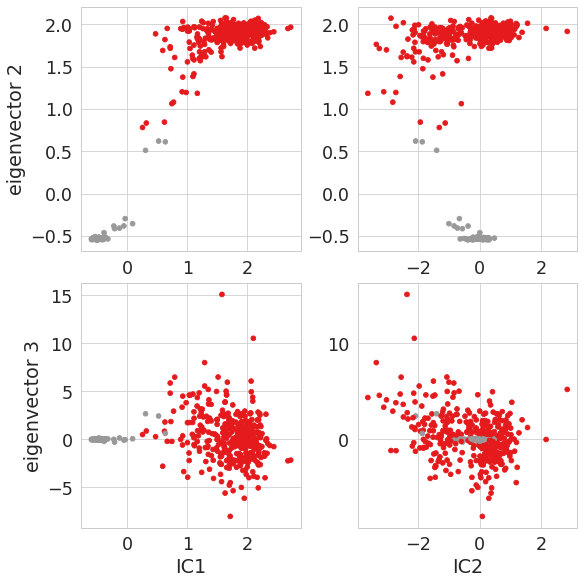

In [55]:
# Check the values of eigenvector along IC
with sns.plotting_context('paper', font_scale=2):
    fig, axes = plt.subplots(2,2, figsize=(8,8), constrained_layout=True)
    for i_set, row in enumerate(axes):
        row[0].scatter(x=kmeans_mod.clustercenters[:, 0], y = msm.eigenvectors_right()[:, i_set+1], c=msm.metastable_assignments, cmap='Set1')
        row[1].scatter(x=kmeans_mod.clustercenters[:, 1], y = msm.eigenvectors_right()[:, i_set+1], c=msm.metastable_assignments, cmap='Set1')
        
    axes[1][0].set_xlabel(f'IC1')
    axes[1][1].set_xlabel(f'IC2')
    axes[0][0].set_ylabel(f'eigenvector 2')
    axes[1][0].set_ylabel(f'eigenvector 3')
    
    plt.locator_params(nbins=5, axis='both')
    plt.savefig(fig_dir.joinpath(f'egvs_detailed.png'), bbox_inches='tight')    
    plt.show()

***
### Sample cluster center

In [84]:
is_single_core = True
if is_single_core: 
    samples = msm.sample_by_distributions(max_dists, 100)
else: 
    samples = msm.sample_by_distributions(dists, 100)
    
ref = md.load(ref_path)

state_out_dir = base_dir.joinpath('states')
state_out_dir.mkdir(exist_ok=True, parents=True)

In [86]:
states = []

for sample_ix in range(len(samples)):

    outfile = str(state_out_dir.joinpath(f'{n_sets}sets_state_{sample_ix}_is_single_core-{is_single_core}.pdb'))
    
    traj = pm.coordinates.save_traj(traj_paths, samples[sample_ix], 
                                 outfile=None, top=top_path)
    traj.superpose(reference=ref)
    states.append(traj)
    traj.save_pdb(str(outfile))
    
rmsds = [md.rmsd(target=x, reference=ref) for x in states]
rmsds_df = pd.DataFrame({f"state_{i}": rmsd*10 for i, rmsd in enumerate(rmsds)}).melt()

100%|█████████████████████| 43/43 [00:00<00:00, 1569.63it/s]


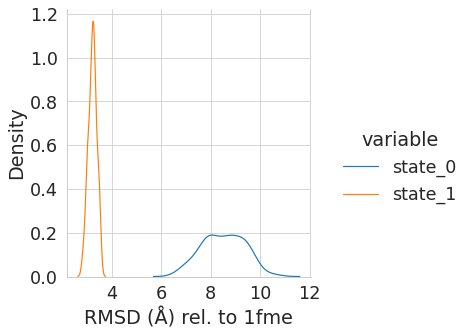

In [87]:
with sns.plotting_context('paper', font_scale=2):
    sns.displot(data=rmsds_df, hue='variable', x='value', kind='kde')
    plt.xlabel(f'RMSD (Å) rel. to 1fme')
    plt.grid(visible=True, axis='both')
    plt.savefig(fig_dir.joinpath(f'{n_sets}sets_rmsd_to_xtal_single_core-{is_single_core}.png'), bbox_inches='tight')

***
### Sample extreme eigenvalues

In [88]:
samples = {}
for i in range(n_egv):
    egv_max = msm.eigenvectors_right()[:, i+1].argmax()
    egv_min = msm.eigenvectors_right()[:, i+1].argmin()
    egv_zero = abs(msm.eigenvectors_right()[:, i+1]).argmin()
    samples[f'egv{i+2}_max_{egv_max}'] = msm.sample_by_state(100, [egv_max])
    samples[f'egv{i+2}_min_{egv_min}'] = msm.sample_by_state(100, [egv_min])
    samples[f'egv{i+2}_zero_{egv_zero}'] = msm.sample_by_state(100, [egv_zero])

In [89]:
rmsds = []

with open(state_out_dir.joinpath('out.dat'), 'w') as f: 
    f.writelines(f'Protein {protein}; hp_id {hp_ix}\n')
    
    for n, sample in samples.items():
        outfile = str(state_out_dir.joinpath(f'{n}.pdb'))

        traj = pm.coordinates.save_traj(traj_paths, sample, outfile=None, top=top_path)
        traj.superpose(reference=ref)
        states.append(traj)
        traj.save_pdb(str(outfile))

        # Compute rg
        rg = md.compute_rg(traj)
        ave_rg, std_rg = np.mean(rg), np.std(rg)

        # Compute rmsd within samples
        rmsd_list = []
        for i in range(len(traj)):
            rmsd_list.append(md.rmsd(traj, traj[i]))
        rmsd_array = np.array(rmsd_list)*10
        ave_rmsd, std_rmsd = np.mean(rmsd_array), np.std(rmsd_array)
        
        # Compute rmsd wrt ref
        rmsd = md.rmsd(target=traj, reference=ref)*10
        ave_ref_rmsd, std_ref_rmsd = np.mean(rmsd), np.std(rmsd)
        rmsds.append(rmsd)
        
        f.writelines(f'{n}\naverage_rg {ave_rg}, std_rg {std_rg}\naverage_rmsd {ave_rmsd}, std_rmsd {std_rmsd}\nave_ref_rmsd {ave_ref_rmsd}, std_ref_rmsd {std_ref_rmsd}\n\n')
    
#rmsds = [md.rmsd(target=x, reference=ref) for x in states]
rmsds_df = pd.DataFrame({f"state_{i}": rmsd for i, rmsd in enumerate(rmsds)}).melt()


100%|█████████████████████| 45/45 [00:00<00:00, 1452.21it/s]


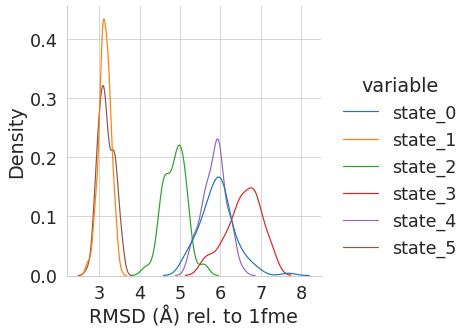

In [90]:
with sns.plotting_context('paper', font_scale=2):
    sns.displot(data=rmsds_df, hue='variable', x='value', kind='kde')
    plt.xlabel(f'RMSD (Å) rel. to 1fme')
    plt.grid(visible=True, axis='both')
    plt.savefig(fig_dir.joinpath(f'{n_egv}egvs_extreme_rmsd_to_xtal.png'), bbox_inches='tight')

In [91]:
!tar chvfz CLN.tar.gz ./CLN

./CLN/
./CLN/.ipynb_checkpoints/
./CLN/hp52_dist./
./CLN/hp52_dist./dtrajs/
./CLN/hp52_dist./dtrajs/CLN025-0-protein-008.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-035.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-046.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-040.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-000.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-003.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-045.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-048.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-013.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-036.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-034.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-016.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-032.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-004.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-047.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-038.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-030.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-025.npy
./CLN/hp52_dist./dtrajs/CLN025-0-protein-0